In [1]:
import os
# Change native directory to root
os.chdir(os.path.dirname(os.getcwd()))

In [351]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from joblib import dump
from scipy.stats import norm, multivariate_normal
import lightgbm as lgb
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import pickle as pkl
import joblib as joblib
target = 'net_target+1'

In [362]:
data_train = pd.read_csv('data/extra_train.csv')
data_train

,Unnamed: 0,Month,Hour,cons_target,Solar Generation [W/kW],Outdoor Drybulb Temperature [C],Relative Humidity [%],Diffuse Solar Radiation [W/m2],Direct Solar Radiation [W/m2],day_year,...,net_target,net+1,net-23,net_target+1,net_target-23,net_target_diff,diffuse_solar_radiation+1,direct_solar_radiation+1,relative_humidity+1,drybulb_temp+1
0,0,8,0,0.441346,0.000000,19.4,81.0,0.000000,0.000000,23,...,0.617429,1.411333,2.275800,0.431845,0.506612,-0.029331,0.000000,0.000000,81.0,20.0
1,1,8,1,0.170776,0.000000,20.0,81.0,0.000000,0.000000,24,...,0.431845,0.979417,0.851167,0.394489,0.383397,-0.185584,0.000000,0.000000,87.0,19.4
2,2,8,2,0.116313,0.000000,19.4,87.0,0.000000,0.000000,25,...,0.394489,0.900975,0.834600,0.387705,0.381964,-0.037356,0.000000,0.000000,87.0,19.4
3,3,8,3,0.106422,0.000000,19.4,87.0,0.000000,0.000000,26,...,0.387705,0.922433,0.838167,0.389561,0.382273,-0.006784,0.000000,0.000000,90.0,19.4
4,4,8,4,0.109127,0.000000,19.4,90.0,0.000000,0.000000,27,...,0.389561,0.910483,1.478433,0.388527,0.437649,0.001856,0.000000,0.000000,90.0,18.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43675,43675,7,19,0.802751,31.179167,21.1,81.0,5.389072,5.669881,8754,...,0.862123,2.713900,3.463783,0.720845,0.814933,0.090374,3.295837,4.875197,84.0,20.6
43676,43676,7,20,0.552807,4.070833,20.6,84.0,3.295837,4.875197,8755,...,0.720845,0.935833,0.457167,0.497751,0.437693,-0.141277,0.000000,0.000000,81.0,21.1
43677,43677,7,21,0.189487,0.000000,21.1,81.0,0.000000,0.000000,8756,...,0.497751,2.155017,0.714717,0.650722,0.470007,-0.223094,0.000000,0.000000,79.0,21.7
43678,43678,7,22,0.436347,0.000000,21.7,79.0,0.000000,0.000000,8757,...,0.650722,2.316400,1.659000,0.670971,0.588487,0.152971,0.000000,0.000000,76.0,21.3


In [427]:
model_pt = joblib.load('models/point/lgb_next_step_diff_12march.pkl')
features = model_pt.feature_name()
preds = model_pt.predict(data_train[features])
data_train['preds'] = preds

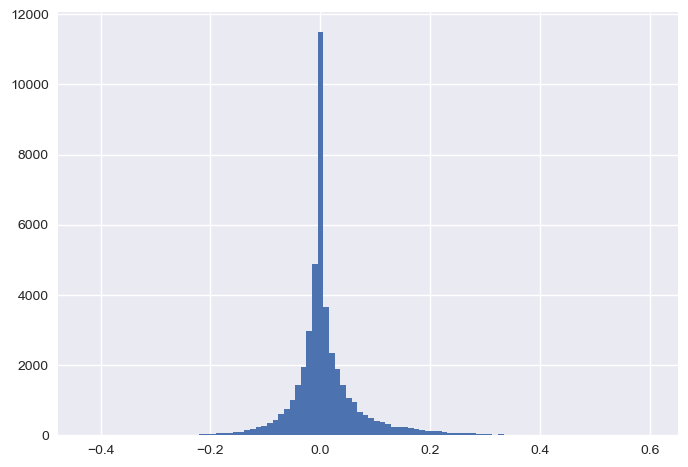

In [428]:
data_train['residual'] = data_train[target] - data_train['preds']
# plot distribution of residuals
plt.hist(data_train['residual'], bins=100)
plt.show()

In [429]:
# maka a dataframe with lead times and the corresponding residual
lead_times = ['residual+'+str(i) for i in range(1, 25)]
residuals = pd.DataFrame(columns=lead_times)
for build in data_train['number'].unique():
    data_train_build = data_train.loc[data_train['number'] == build]
    residuals_build = pd.DataFrame(columns=lead_times, index=data_train_build.index)
    residuals_build['time_step'] = data_train_build['day_year'].values
    # reverse the shift in the data preparation
    residuals_build['Hour'] = data_train_build['Hour'].shift(1).values 
    residuals_build['Month'] = data_train_build['Month'].values
    residuals_build['building'] = data_train_build['number'].values
    residuals_build['residual'] = data_train_build['residual'].values
    for i, lead_time in enumerate(lead_times):
        residuals_build[lead_time] = data_train_build['residual'].shift(-int(i+1))
    # use pdconcat to append the dataframes
    residuals = pd.concat([residuals, residuals_build], axis=0)
# put last 5 columns to the front
cols = residuals.columns.tolist()
cols = cols[-5:] + cols[:-5]
# drop the rows with NaN
residuals = residuals.dropna()
residuals = residuals[cols]

In [432]:
residuals

,time_step,Hour,Month,building,residual,residual+1,residual+2,residual+3,residual+4,residual+5,...,residual+15,residual+16,residual+17,residual+18,residual+19,residual+20,residual+21,residual+22,residual+23,residual+24
1,24.0,0.0,8.0,1.0,0.000814,-0.000447,0.000196,-0.000430,0.006446,-0.000452,...,-0.020601,0.166677,0.003521,0.293825,0.108027,-0.041076,-0.142371,-0.107216,0.027953,-0.008197
2,25.0,1.0,8.0,1.0,-0.000447,0.000196,-0.000430,0.006446,-0.000452,0.027857,...,0.166677,0.003521,0.293825,0.108027,-0.041076,-0.142371,-0.107216,0.027953,-0.008197,0.002003
3,26.0,2.0,8.0,1.0,0.000196,-0.000430,0.006446,-0.000452,0.027857,-0.002468,...,0.003521,0.293825,0.108027,-0.041076,-0.142371,-0.107216,0.027953,-0.008197,0.002003,0.000478
4,27.0,3.0,8.0,1.0,-0.000430,0.006446,-0.000452,0.027857,-0.002468,-0.005695,...,0.293825,0.108027,-0.041076,-0.142371,-0.107216,0.027953,-0.008197,0.002003,0.000478,0.005511
5,28.0,4.0,8.0,1.0,0.006446,-0.000452,0.027857,-0.002468,-0.005695,-0.016003,...,0.108027,-0.041076,-0.142371,-0.107216,0.027953,-0.008197,0.002003,0.000478,0.005511,0.032748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43651,8730.0,18.0,7.0,5.0,0.108512,-0.199288,0.044028,0.105598,-0.048408,0.065762,...,-0.003945,-0.013253,0.103345,0.011372,0.058796,0.064881,-0.018435,0.160736,0.168802,0.024279
43652,8731.0,19.0,7.0,5.0,-0.199288,0.044028,0.105598,-0.048408,0.065762,0.003094,...,-0.013253,0.103345,0.011372,0.058796,0.064881,-0.018435,0.160736,0.168802,0.024279,-0.030312
43653,8732.0,20.0,7.0,5.0,0.044028,0.105598,-0.048408,0.065762,0.003094,0.025360,...,0.103345,0.011372,0.058796,0.064881,-0.018435,0.160736,0.168802,0.024279,-0.030312,0.152172
43654,8733.0,21.0,7.0,5.0,0.105598,-0.048408,0.065762,0.003094,0.025360,-0.025486,...,0.011372,0.058796,0.064881,-0.018435,0.160736,0.168802,0.024279,-0.030312,0.152172,0.089130


In [433]:
# find a correlation matrix between lead times
corr = residuals.iloc[:, 5:].corr()
# for each hour, find the correlation between the lead times
corr_hour = {}
stds = {}
for hour in range(0, 24):
    corr_hour[hour] = residuals.loc[residuals['Hour'] == hour].iloc[:, 5:].corr()
    stds[hour] = residuals.loc[residuals['Hour'] == hour].iloc[:, 5:].std()
# save the correlation matrix and the standard deviations to pickle files
with open('models/residuals_corr/corr.pkl', 'wb') as f:
    pkl.dump(corr, f)
with open('models/residuals_corr/corr_hour.pkl', 'wb') as f:
    pkl.dump(corr_hour, f)

In [436]:
# convert the correlation matrix for each hour to a covariance matrix
cov_hour = {}
for hour in range(0, 24):
    cov_hour[hour] = np.outer(stds[hour], stds[hour]) * corr_hour[hour]
# save the covariance matrix to a pickle file
with open('models/residuals_corr/cov_hour.pkl', 'wb') as f:
    pkl.dump(cov_hour, f)

In [441]:
rv_mvnorm = multivariate_normal([0]*24, cov_hour[15])
simulation_mvnorm = rv_mvnorm.rvs(10)
simulation_uniform = pd.DataFrame(data=simulation_mvnorm, 
                                              columns = corr.columns)
simulation_uniform

,residual+1,residual+2,residual+3,residual+4,residual+5,residual+6,residual+7,residual+8,residual+9,residual+10,...,residual+15,residual+16,residual+17,residual+18,residual+19,residual+20,residual+21,residual+22,residual+23,residual+24
0,0.048476,-0.018607,0.139960,-0.056653,0.021985,-0.080727,-0.009745,-0.084722,0.017453,0.123280,...,-0.057454,-0.113801,0.160389,-0.001591,-0.002323,-0.029449,-0.001963,0.051816,-0.002749,-0.008097
1,0.055815,0.022968,0.134759,-0.068626,-0.005737,-0.064515,0.017105,-0.004771,0.028000,-0.041609,...,0.066476,-0.057232,-0.010058,-0.088531,-0.025404,0.035305,0.031002,-0.125850,0.004056,-0.088156
2,-0.065498,-0.021385,0.076401,0.066085,-0.036936,-0.038869,-0.105622,-0.079251,0.006142,0.065705,...,-0.024112,0.000597,0.006417,-0.030521,-0.035287,-0.050996,0.023941,-0.110345,0.016457,-0.104757
3,0.101271,-0.028946,0.035790,0.015958,0.159499,0.001848,0.043281,-0.206363,0.058974,0.033485,...,0.001456,-0.022333,-0.044328,-0.109230,0.133462,0.112670,-0.027315,0.050512,-0.034593,-0.018096
4,-0.100729,0.035450,-0.010512,0.062163,0.109889,-0.040200,0.025051,-0.041239,0.050897,0.073780,...,-0.085495,-0.085834,0.046686,-0.087684,0.012002,0.008415,-0.031262,-0.081584,-0.074878,0.008080
5,-0.038064,0.028263,0.146654,-0.063233,0.084842,0.081917,0.162670,-0.025878,0.038034,0.044609,...,0.088926,-0.017793,0.030535,0.036150,-0.131977,-0.011375,0.074652,-0.120862,-0.086094,-0.172848
6,0.080241,-0.040681,-0.060440,-0.001999,0.069707,0.153838,0.016063,0.004840,0.048771,-0.014458,...,0.125625,0.078386,0.020897,-0.153919,-0.060483,0.182156,0.086958,0.049206,0.019259,0.053272
7,0.101751,-0.083693,0.164483,0.007765,0.069407,0.084908,0.014272,-0.053200,0.060086,-0.020471,...,-0.002851,-0.026511,0.031317,0.100308,-0.012458,0.074858,0.146429,-0.018201,0.084465,0.038257
8,-0.039122,-0.047180,-0.025623,-0.030591,0.103479,0.074008,-0.085969,0.037437,0.036244,0.089456,...,0.039012,-0.039093,0.001795,-0.014144,-0.000916,0.040480,0.086597,0.041840,-0.089667,0.082960
9,0.015189,-0.114473,0.102179,0.079228,-0.001817,-0.006400,0.064820,0.065815,0.040906,-0.024894,...,0.011964,0.072001,0.080444,0.106493,0.140963,0.028096,0.111263,0.106852,-0.050885,0.034899


<AxesSubplot:>

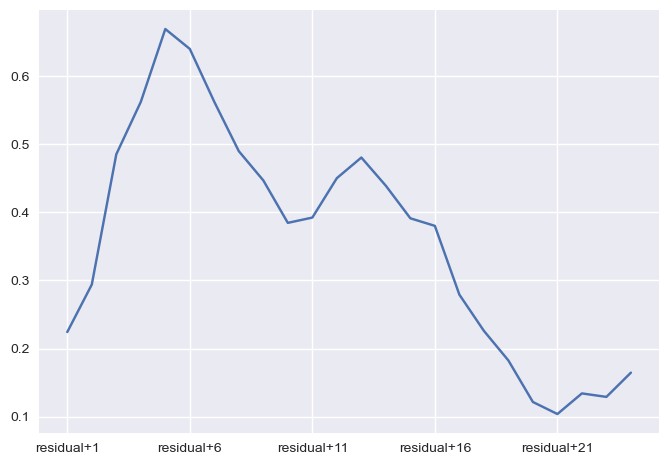

In [442]:
point_row = data_train[64:88]['preds']
point_row.index = simulation_uniform.columns
point_row.plot()

In [443]:
scenarios = simulation_uniform.copy()
# for each row of the simulation add the point forecast
for i in range(simulation_uniform.shape[0]):
    scenarios.iloc[i, :] = simulation_uniform.iloc[i, :] + point_row

<AxesSubplot:>

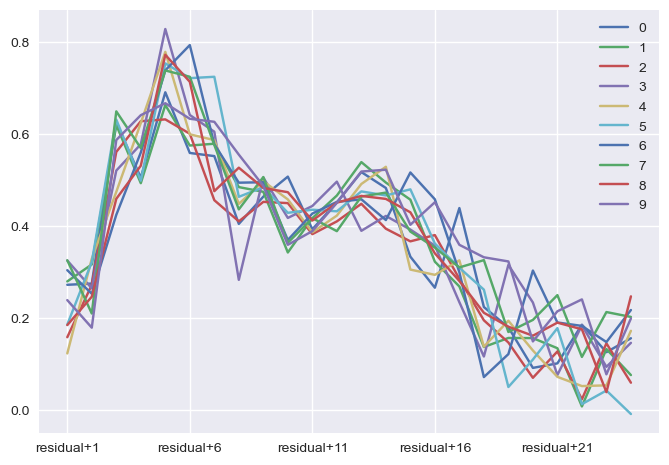

In [444]:
scenarios.T.plot()

In [302]:
data_train[64:68]

,Month,Hour,cons_target,Solar Generation [W/kW],Outdoor Drybulb Temperature [C],Relative Humidity [%],Diffuse Solar Radiation [W/m2],Direct Solar Radiation [W/m2],day_year,number,...,net+1,net-23,net_target+1,net_target-23,diffuse_solar_radiation+1,direct_solar_radiation+1,relative_humidity+1,drybulb_temp+1,net_forecast+1,residual
64,8.0,16.0,0.065114,583.025000,21.7,76.0,5.796058,2.944439,87,1,...,-0.956317,-1.007133,0.227070,0.222675,6.102559,5.332719,81.0,20.6,0.290305,0.063236
65,8.0,17.0,0.084100,420.066667,20.6,81.0,6.102559,5.332719,88,1,...,0.890417,-0.318483,0.386792,0.282235,6.082219,6.180017,81.0,20.0,0.403902,0.017111
66,8.0,18.0,0.224518,236.779167,20.0,81.0,6.082219,6.180017,89,1,...,3.944067,1.937817,0.650899,0.477380,5.480639,5.786897,78.0,20.0,0.452432,-0.198466
67,8.0,19.0,0.529241,77.516667,20.0,78.0,5.480639,5.786897,90,1,...,4.272350,1.548717,0.679292,0.443727,3.178054,4.912655,81.0,19.4,0.472881,-0.206411


<AxesSubplot:>

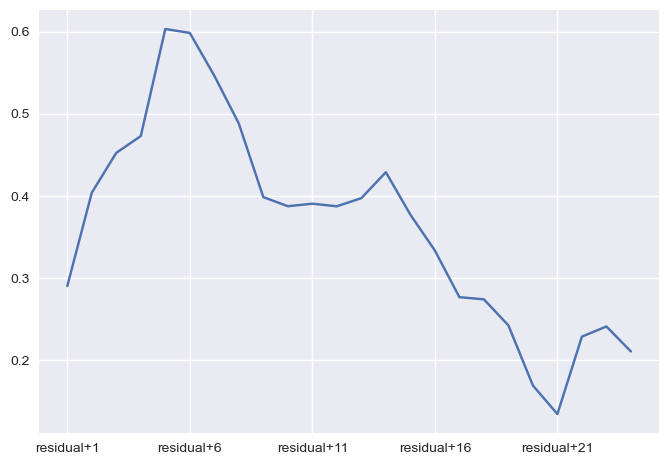

In [301]:
point_row.plot()

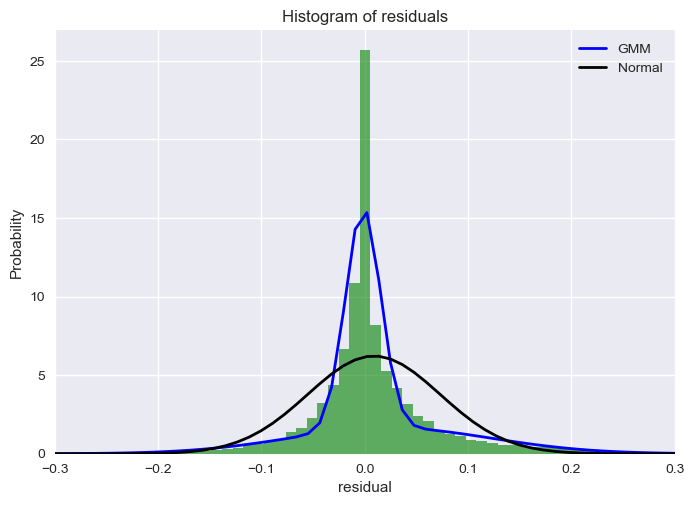

In [452]:
# estimate by a normal distribution
mu, std = norm.fit(data_train['residual'])
# fit to a gaussian mixture model
gmm = GaussianMixture(n_components=2).fit(data_train['residual'].values.reshape(-1, 1))
# plot the histogram and the normal distribution
plt.hist(data_train['residual'], bins=100, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = np.exp(gmm.score_samples(x.reshape(-1,1)))
# plot the PDF
plt.plot(x, y, 'b-', lw=2, label='GMM')
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal')
plt.legend()
# xlimit
plt.xlim(-0.3, 0.3)
# labels and stuff
plt.xlabel('residual')
plt.ylabel('Probability')
plt.title('Histogram of residuals')
plt.show()

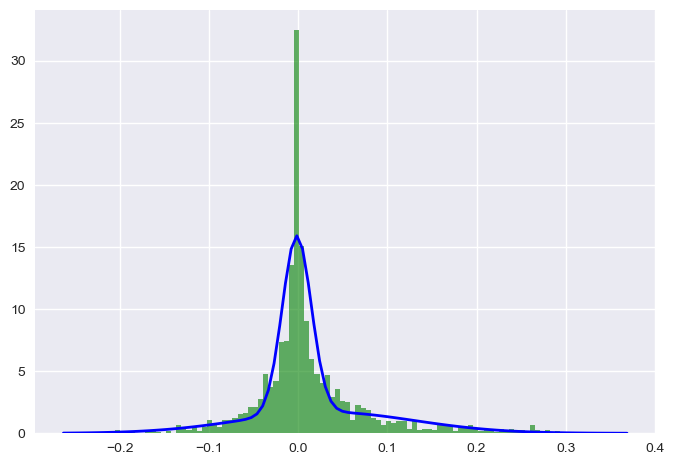

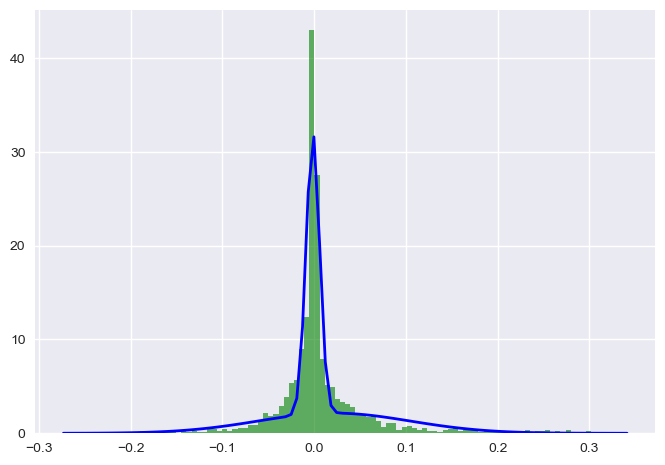

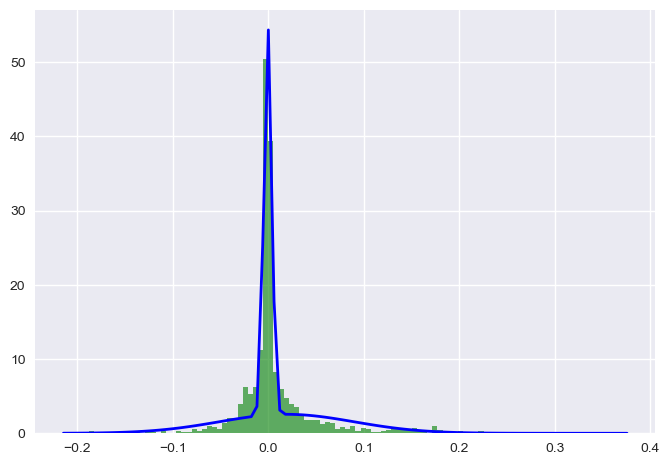

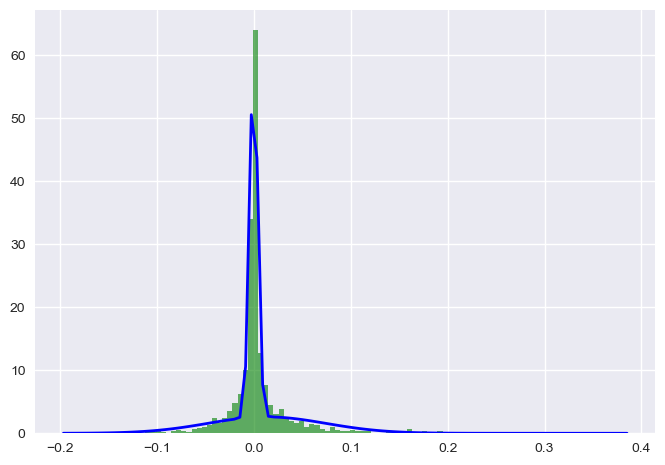

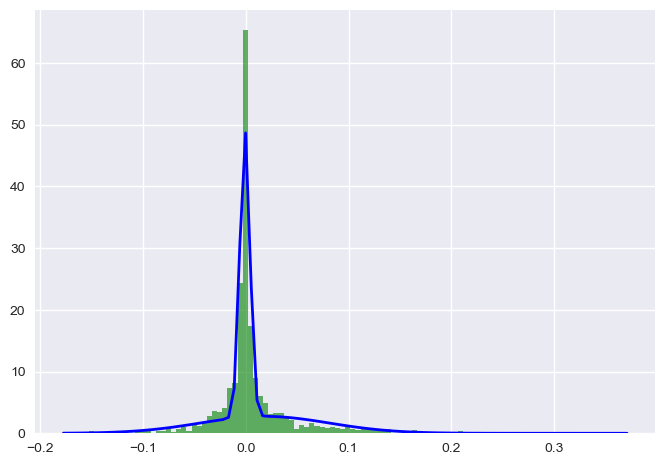

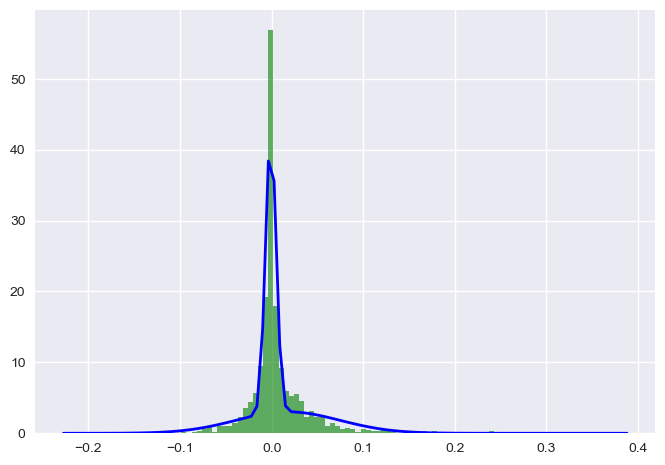

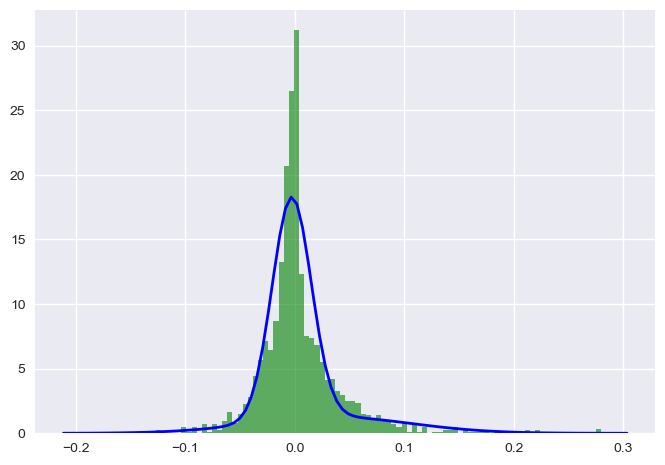

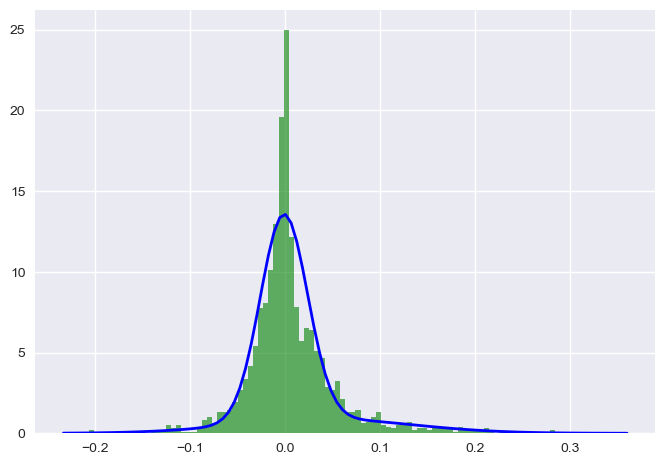

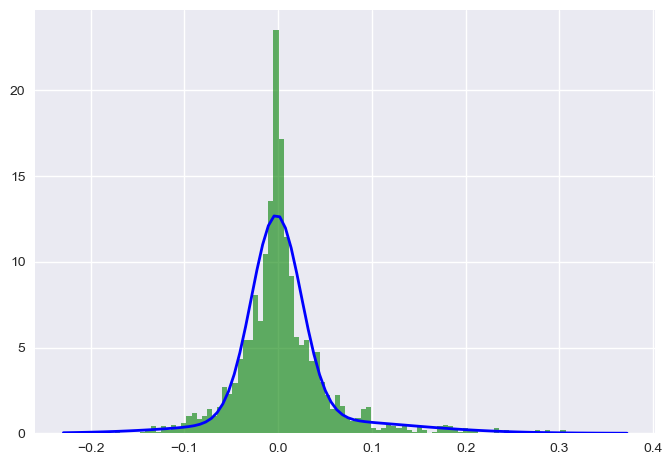

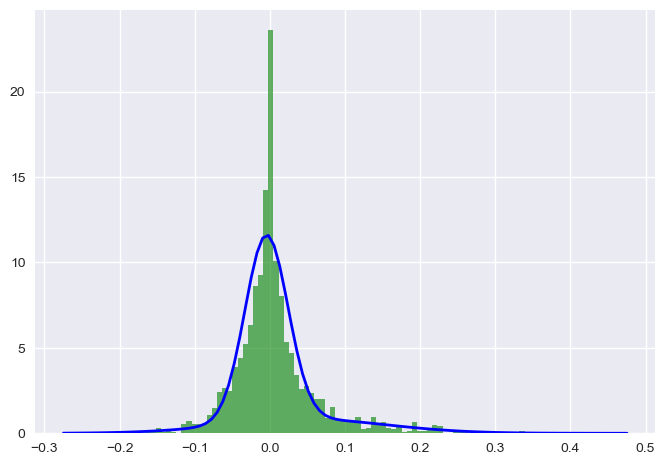

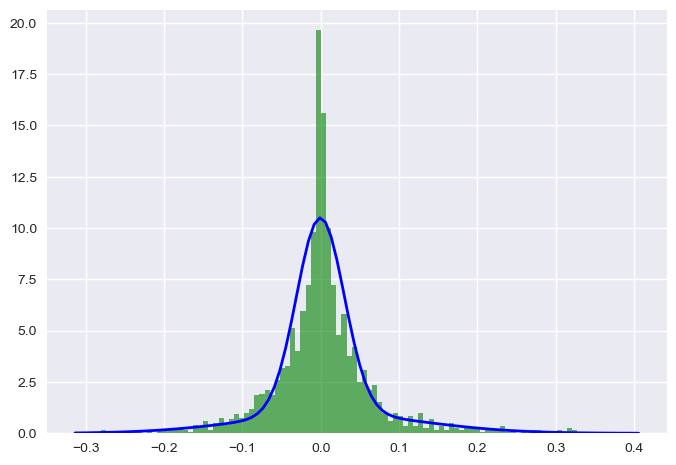

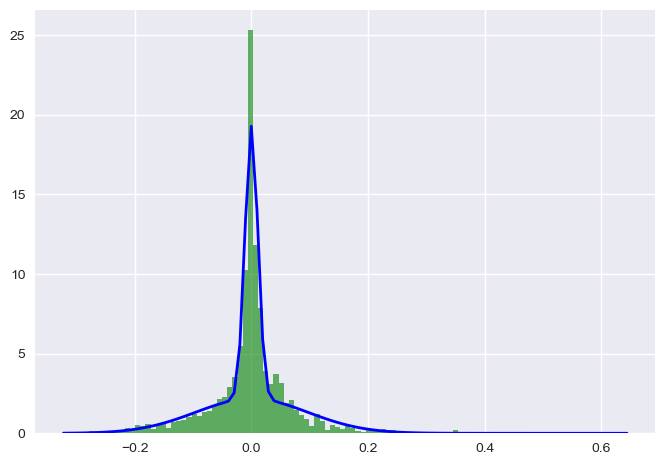

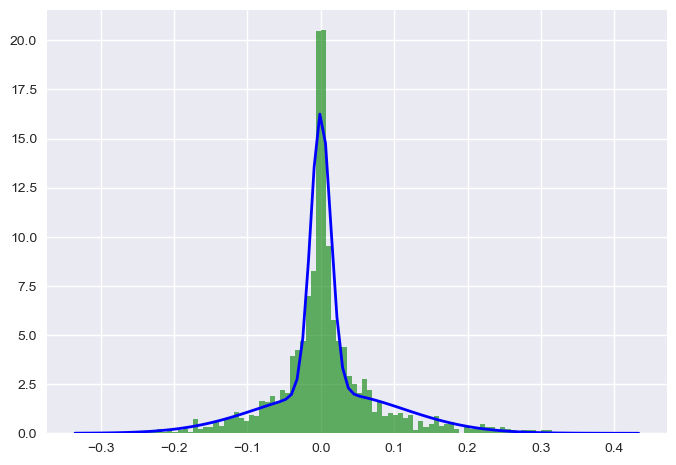

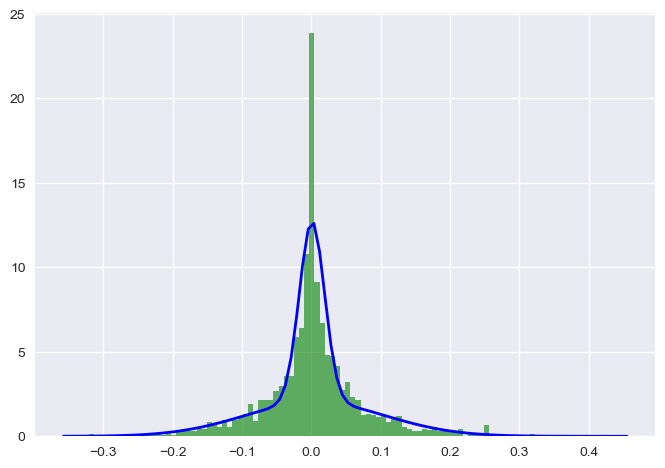

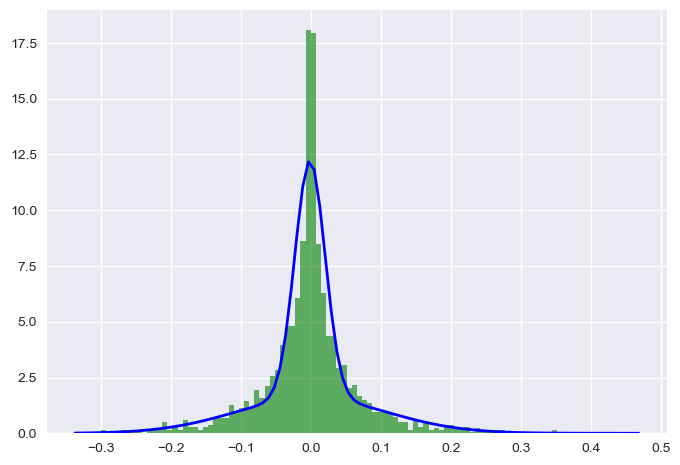

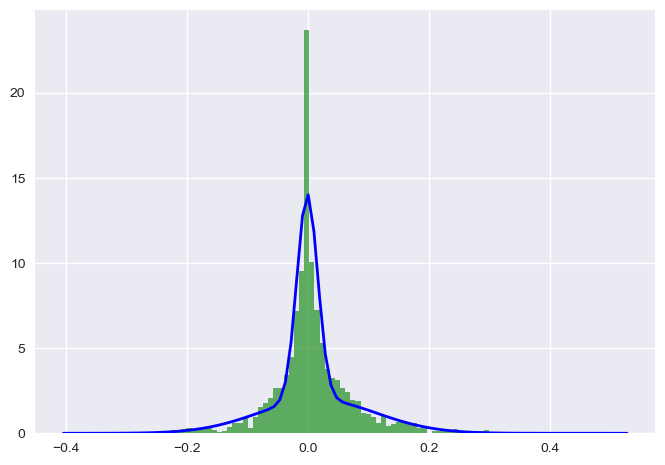

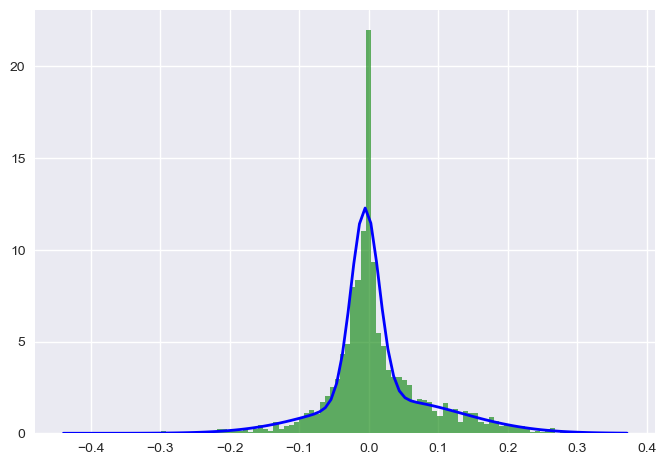

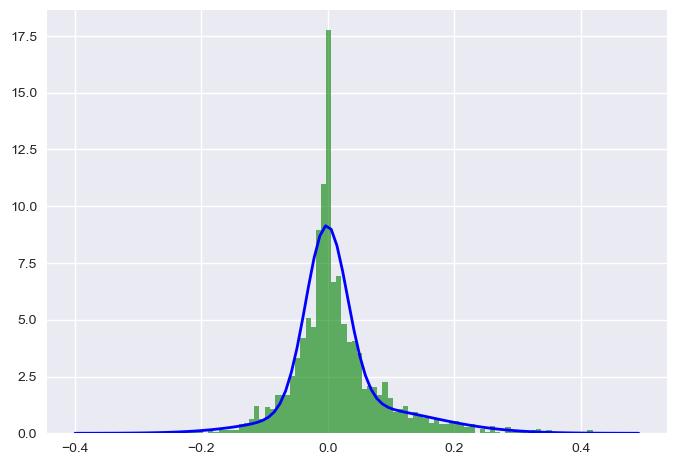

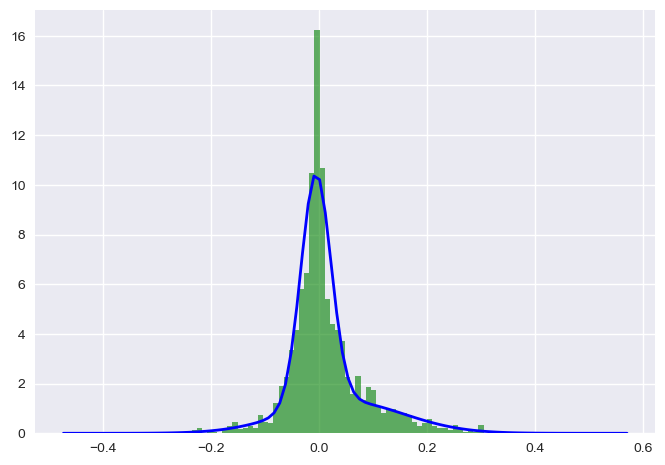

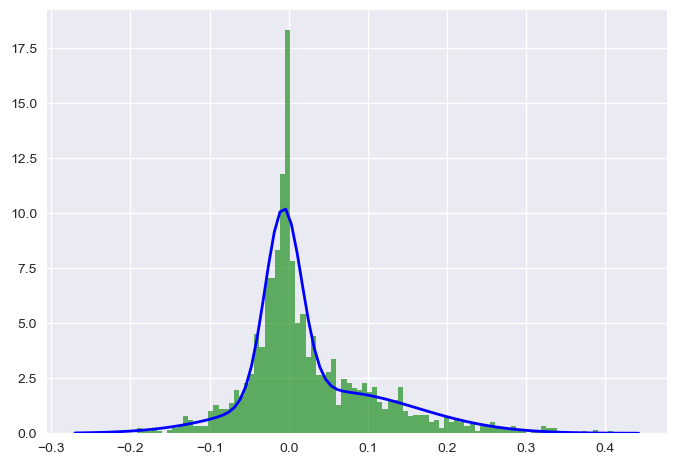

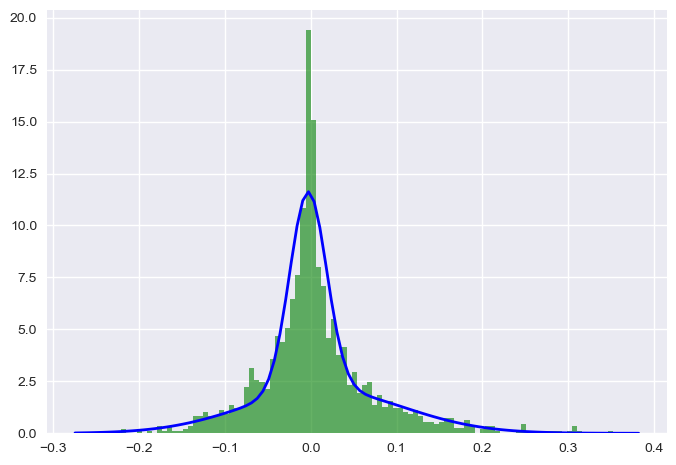

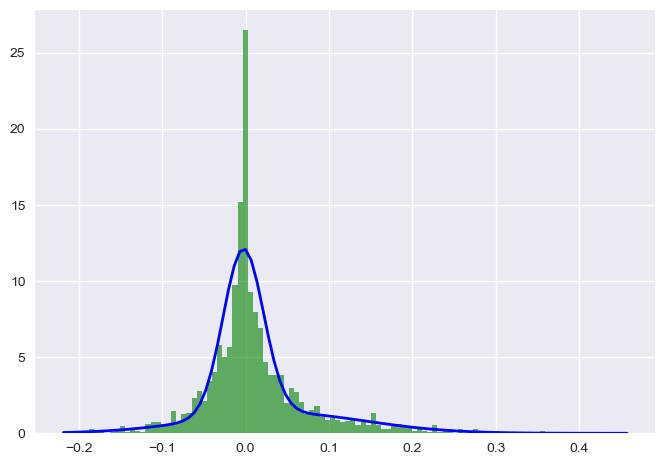

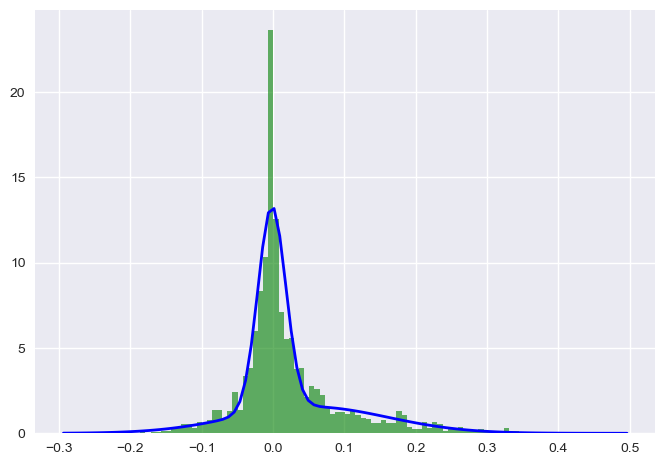

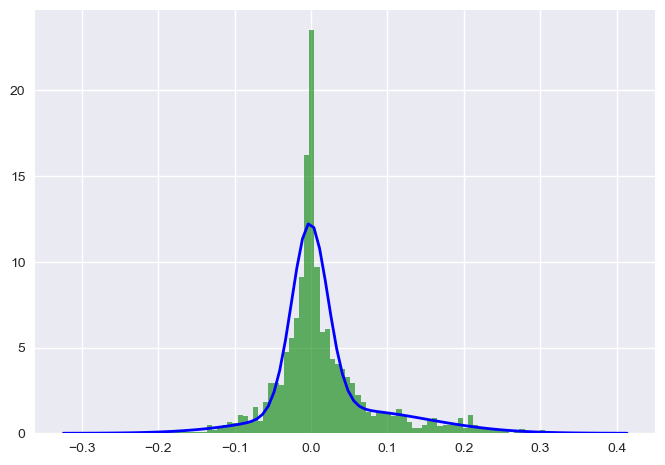

In [445]:
# find gmm for residuals for every Hour
gmm_dict = {}
for hour in data_train['Hour'].unique():
    gmm_dict[hour] = GaussianMixture(n_components=2).fit(data_train.loc[data_train['Hour'] == hour, 'residual'].values.reshape(-1, 1))
    # save the gmm parameters with joblib
    dump(gmm_dict[hour], 'models/gmm/gmm_residual_hour_{}.joblib'.format(int(hour)))
    # plot the histogram and the gmm
    plt.hist(data_train.loc[data_train['Hour'] == hour, 'residual'], bins=100, density=True, alpha=0.6, color='g')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = np.exp(gmm_dict[hour].score_samples(x.reshape(-1,1)))
    # plot the PDF
    plt.plot(x, y, 'b-', lw=2)
    plt.show()

<AxesSubplot:xlabel='Month'>

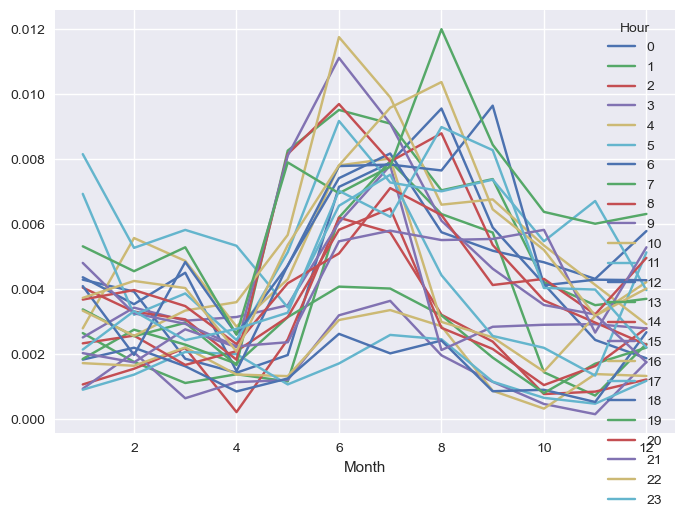

In [446]:
# show variance by hour and month
data_train.groupby(['Month', 'Hour']).var()['residual'].unstack().plot()

In [448]:
# calculate variance by hour and month
var_df = data_train.groupby(['Month', 'Hour']).std()['residual'].unstack()
# turn index and column names to int
var_df.index = var_df.index.astype(int)
var_df.columns = var_df.columns.astype(int)
var_df
# save to csv to data folder
var_df.to_csv('data/variance_hour_month.csv')

In [8]:
data_train.groupby(['Month', 'Hour']).var()[target].unstack()

Hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
Month,,,,,,,,,,,,,,,,,,,,,
1.0,0.008780,0.009453,0.011057,0.008894,0.007211,0.008951,0.009030,0.009625,0.012868,0.023625,...,0.009749,0.013043,0.010172,0.010501,0.009127,0.011829,0.011501,0.010236,0.009861,0.009635
2.0,0.009020,0.010102,0.010975,0.009540,0.007707,0.010563,0.008317,0.010008,0.013484,0.018229,...,0.009212,0.007439,0.005861,0.008532,0.007080,0.006751,0.009089,0.008583,0.009761,0.009362
3.0,0.006133,0.004070,0.005447,0.005516,0.004225,0.007584,0.007361,0.011373,0.011708,0.011075,...,0.009634,0.009608,0.009134,0.009434,0.006447,0.005640,0.008062,0.006441,0.004689,0.003908
4.0,0.003149,0.004095,0.004488,0.003935,0.003359,0.005374,0.006013,0.007058,0.005587,0.008783,...,0.010151,0.009136,0.005823,0.005992,0.004837,0.004895,0.005090,0.006808,0.004631,0.004757
5.0,0.007062,0.004691,0.005017,0.004359,0.005061,0.008463,0.011760,0.013148,0.010566,0.014658,...,0.019374,0.021323,0.013415,0.014250,0.006910,0.008050,0.009889,0.008736,0.006849,0.006172
6.0,0.008767,0.005664,0.005921,0.005029,0.005252,0.009354,0.015926,0.019651,0.013838,0.018007,...,0.019360,0.024014,0.020574,0.013483,0.007030,0.008154,0.012141,0.012149,0.011599,0.012011
7.0,0.007481,0.006834,0.005596,0.005469,0.004940,0.010525,0.020187,0.020309,0.019917,0.024276,...,0.022012,0.020010,0.019927,0.015748,0.008588,0.010170,0.014269,0.010597,0.010995,0.012185
8.0,0.009825,0.006257,0.007541,0.005101,0.005927,0.007829,0.009685,0.008221,0.008466,0.010688,...,0.017321,0.018683,0.019169,0.020845,0.015580,0.015326,0.015972,0.016433,0.016456,0.017201
9.0,0.006849,0.005061,0.003456,0.002577,0.002552,0.004440,0.008445,0.010735,0.008599,0.012900,...,0.021093,0.018838,0.015282,0.015449,0.011290,0.011006,0.009183,0.013058,0.011818,0.011635
